# Example pipeline

A compact version of the WMAP tutorial for talks 

First, let us import the required packages/modules.

In [1]:
# Builtin 
import os
# External packages 
import numpy as np
import healpy as hp
import astropy.units as u
import corner
import matplotlib.pyplot as plt
import cmasher as cmr
# IMAGINE
import imagine as img
import imagine.observables as img_obs
## "WMAP" field factories
from imagine.fields.hamx import BregLSA, BregLSAFactory
from imagine.fields.hamx import TEregYMW16, TEregYMW16Factory
from imagine.fields.hamx import CREAna, CREAnaFactory

## Preparing the mock data

Let's make a very low resolution map of synchrotron total I and Faraday depth from the WMAP model, but without including a random compnent (this way, we can limit the ensemble size to $1$, speeding up the inference):

In [3]:
## Sets the resolution
nside=2
size = 12*nside**2 

# Generates the fake datasets 
sync_dset = img_obs.SynchrotronHEALPixDataset(data=np.empty(size)*u.K, 
                                              frequency=23, typ='I')
fd_dset = img_obs.FaradayDepthHEALPixDataset(data=np.empty(size)*u.rad/u.m**2)

# Appends them to an Observables Dictionary
trigger = img_obs.Measurements(sync_dset, fd_dset)

# Prepares the Hammurabi simmulator for the mock generation
mock_generator = img.simulators.Hammurabi(measurements=trigger)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


We will feed the `mock_generator` simulator with selected Dummy fields.

In [4]:
# BregLSA field
breg_lsa = BregLSA(parameters={'b0':3, 'psi0': 27.0, 'psi1': 0.9, 'chi0': 25.0})

# CREAna field
cre_ana = CREAna(parameters={'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
                             'r0': 5.0, 'z0': 1.0,
                             'E0': 20.6, 'j0': 0.0217})

# TEregYMW16 field
tereg_ymw16 = TEregYMW16(parameters={})

In [5]:
## Generate mock data (run hammurabi)
outputs = mock_generator([breg_lsa, cre_ana, tereg_ymw16])

To make a realistic mock, we add to these outputs, which where constructed from a model with known parameter, some noise, which assumed to be proportional to the average synchrotron intensity.

In [6]:
## Collect the outputs
mockedI = outputs[('sync', 23.0, nside, 'I')].global_data[0]
mockedRM = outputs[('fd', None, nside, None)].global_data[0]
dm=np.mean(mockedI)
dv=np.std(mockedI)

## Add some noise that's just proportional to the average sync I by the factor err
err=0.01
dataI = (mockedI + np.random.normal(loc=0, scale=err*dm, size=size)) << u.K
errorI = (err*dm) << u.K
sync_dset = img_obs.SynchrotronHEALPixDataset(data=dataI, error=errorI,
                                              frequency=23, typ='I')

## Just 0.01*50 rad/m^2 of error for noise.  
dataRM = (mockedRM + np.random.normal(loc=0.,scale=err*50.,size=12*nside**2))*u.rad/u.m/u.m
errorRM = (err*50.) << u.rad/u.m**2
fd_dset = img_obs.FaradayDepthHEALPixDataset(data=dataRM, error=errorRM)

We are ready to include the above data in `Measurements` and  objects

/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


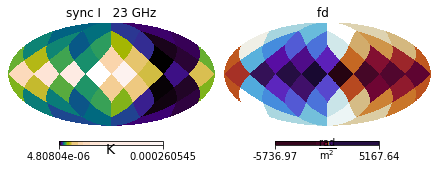

In [7]:
mock_data = img_obs.Measurements(sync_dset, fd_dset)

mock_data.show()

## Assembling the pipeline

After preparing our mock data, we can proceed with the set up of the IMAGINE pipeline. First, we initialize the `Likelihood`, using the mock observational data

In [8]:
## Use an ensemble to estimate the galactic variance
likelihood = img.likelihoods.EnsembleLikelihood(mock_data)

Then, we prepare the `FieldFactory` list:

In [9]:
## WMAP B-field, vary only b0 and psi0
breg_factory = BregLSAFactory()
breg_factory.active_parameters = ('b0', 'psi0')
breg_factory.priors = {'b0':  img.priors.FlatPrior(xmin=0., xmax=10.), 
                      'psi0': img.priors.FlatPrior(xmin=0., xmax=50.)}
## Fixed CR model
cre_factory = CREAnaFactory()
## Fixed FE model
fereg_factory = TEregYMW16Factory()

# Final Field factory list
factory_list = [breg_factory, cre_factory, fereg_factory]

We initialize the `Simulator`, in this case: `Hammurabi` .

In [10]:
simulator = img.simulators.Hammurabi(measurements=mock_data)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


Finally, we initialize and setup the `Pipeline` itself, using the `Multinest` sampler.

In [11]:
# Assembles the pipeline using MultiNest as sampler
pipeline = img.pipelines.MultinestPipeline(run_directory='../runs/tutorial_example/',
                                           simulator=simulator, 
                                           show_progress_reports=True,
                                           factory_list=factory_list, 
                                           likelihood=likelihood, 
                                           ensemble_size=1, n_evals_report=15)
pipeline.sampling_controllers = {'n_live_points': 500}

We set a run directory, `'runs/tutorial_example'` for storing this state of the run and MultiNest's chains. This is *strongly recommended*, as it makes it easier to resume a crashed or interrupted IMAGINE run.

Since there are no stochastic fields in this model, we chose an ensemble size of 1.

Loading the pipeline from a previos run

  analysing data from ../runs/tutorial_example_completed/chains/multinest_.txt



**Posterior report:**

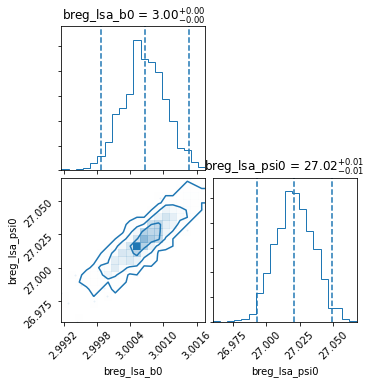

<IPython.core.display.Math object>

**Evidence report:**

<IPython.core.display.Math object>

In [18]:
previous_pipeline = img.load_pipeline('../runs/tutorial_example_completed/')
previous_pipeline(save_pipeline_state=False);

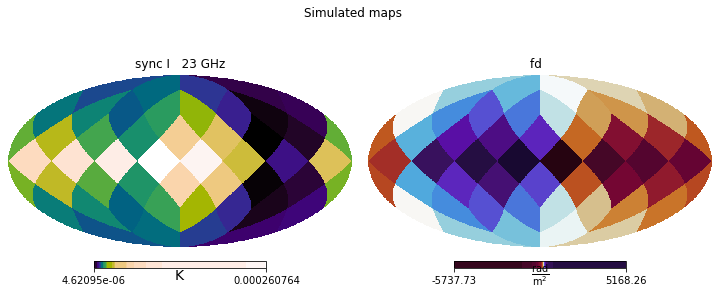

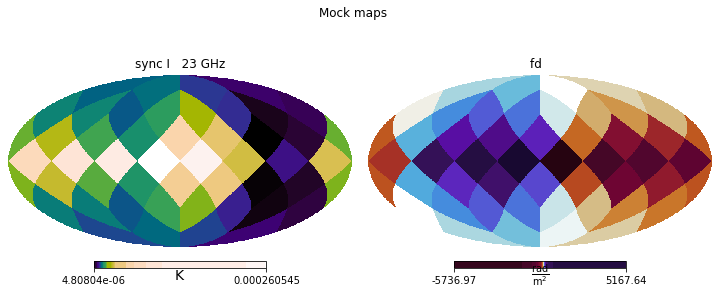

In [23]:
plt.figure(figsize=(10,4))
plt.suptitle('Simulated maps')
previous_pipeline.MAP_simulation.show()
plt.figure(figsize=(10,4))
plt.suptitle('Mock maps')
mock_data.show()